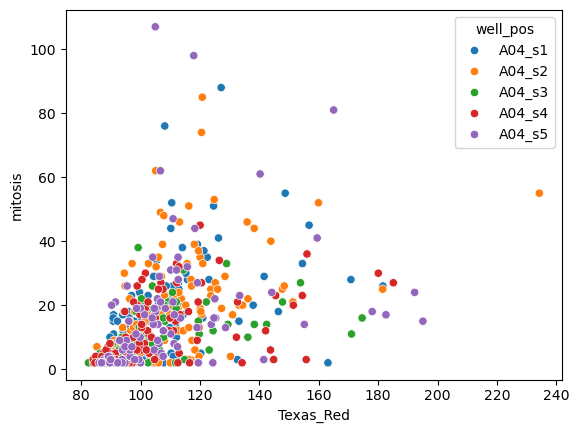

In [13]:
import sys, os
from pathlib import Path
# import napari # type: ignore
import numpy as np
import pandas as pd
# import trackpy as tp
# from scipy import ndimage as ndi
import matplotlib.pyplot as plt
plt.ion()
import seaborn as sns

sys.path.append('/Users/ajitj/Google Drive/ImageAnalysis/cell_analysis')
import cellaap_analysis
hela = pd.read_excel('/Users/ajitj/Desktop/RPE1-U2OS/M3_compiled.xlsx')
# m6 = pd.read_excel('/Users/ajitj/Desktop/RPE1-U2OS/M3_compiled.xlsx')
rpe1 = pd.read_excel('/Users/ajitj/Desktop/rpe1.xlsx')
# Remove 0's and drop the categorical column
hela = hela[hela.Texas_Red>0].copy()
sns.scatterplot(x = "Texas_Red", y="mitosis", hue="well_pos", data=rpe1)
hela.sort_values(by="Texas_Red", inplace=True)
hela.drop(columns=["well_pos"], inplace=True)
hela.head()
hela.Texas_Red = hela.Texas_Red - hela.Texas_Red.min()

rpe1 = rpe1[rpe1.Texas_Red>0].copy()
rpe1.sort_values(by="Texas_Red", inplace=True)
rpe1.drop(columns=["well_pos"], inplace=True)
rpe1.head()
rpe1.Texas_Red = rpe1.Texas_Red - rpe1.Texas_Red.min()

Examine the dose-response curves in the Chen et al. paper. To clarify the trend in the data, we bin the cells according to how much mCherry (eSAC) they have and the calculate the mean value in each bin. These means are overlaid on the raw data. The fits are performed on these mean values because they summarize the trend in the data.

In [3]:
from scipy.optimize import curve_fit
# The equation for a 4-parameter sigmoid. This is what we used
# to fit the dose-response data in the paper.

def sigmoid_4par(x, base, top, exponent, ec50):

    return base + (top - base)*(x**exponent)/(x**exponent+ec50**exponent)

In [40]:
def fit_model(xy_data: pd.DataFrame, plot: True, quant_fraction = None, bin_size = None) -> (pd.DataFrame, dict): # type: ignore
    '''
    Function to fit the dose-response data with a 4-parameter sigmoid.
    Bin range is determined by quantiles. Default is 0.025 and 0.85. The data
    typically contain outliers on the high side, but not the low side. Hence the 
    default values are aysmmetric.
    Inputs:
    xy_data        - dataframe w/ dose as the first column and response as 
                     the second column
    plot           - Boolean to enable plotting
    quant_fraction - quantiles to determine bin range; 
    bin_size       - size of each bin, default is 2.5 (empirical)
    Outputs:
    xy_data        - the input dataframe with bin labels added as a new column
    fit_pars       - dictionary containing fit parameters
    '''
    if quant_fraction is None:
        quant_fraction = [0.025, 0.85]
    quants = np.round(xy_data.iloc[:,0].quantile(quant_fraction)).tolist()

    # 
    if bin_size is None:
        bin_size = 2.5
    bins   = np.arange(quants[0]-bin_size, 1.3*quants[-1], bin_size)

    labels, _ = pd.cut(xy_data.iloc[:, 0], bins, retbins=True)
    xy_data["bins"] = labels

    bin_means = xy_data.groupby("bins").mean()
    # bin_stds  = xy_data.groupby("labels").std()
    # bin_n     = xy_data.groupby("labels").count()

    fits, _ = curve_fit(sigmoid_4par, bin_means.iloc[:,0], bin_means.iloc[:,-1], 
                        p0 = [bin_means.iloc[:,1].min(), bin_means.iloc[:,1].max(), 
                              5, (quants[0] + quants[-1])/ 4
                             ],
                        maxfev = 10000
                       )

    if plot:
        plt.plot(xy_data.iloc[:,0], xy_data.iloc[:,1], 'r.')
        plt.plot(bin_means.iloc[:,0], bin_means.iloc[:,1], 'bo')
        plt.plot(np.arange(0,1.5*quants[-1]), sigmoid_4par(np.arange(0,1.5*quants[-1]),
                                       fits[0], fits[1], fits[2], fits[3]), 'b-')
    
    fit_values = { 'min_duration' : fits[0],
                   'max_duration' : fits[1],
                   'Hill_exponent': fits[2],
                   'EC50'         : fits[3]
                 }
    
    return xy_data, bin_means, fit_values

/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_9627/2761101608.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = xy_data.groupby("bins").mean()


(      Texas_Red  mitosis        bins
 416    0.000000      2.0         NaN
 394    0.537509      2.0  (0.5, 3.0]
 290    0.729759      2.0  (0.5, 3.0]
 280    1.249212      3.0  (0.5, 3.0]
 200    1.414441      3.0  (0.5, 3.0]
 ..          ...      ...         ...
 602  100.199564     17.0         NaN
 532  102.674147     27.0         NaN
 616  109.847939     24.0         NaN
 595  112.638067     15.0         NaN
 217  151.854698     55.0         NaN
 
 [628 rows x 3 columns],
               Texas_Red    mitosis
 bins                              
 (0.5, 3.0]     2.069580   3.166667
 (3.0, 5.5]     4.424290   2.641026
 (5.5, 8.0]     6.742520   3.545455
 (8.0, 10.5]    9.091990   4.762712
 (10.5, 13.0]  11.793851   6.192982
 (13.0, 15.5]  14.445487   9.625000
 (15.5, 18.0]  16.834989  10.565217
 (18.0, 20.5]  19.215836  12.617499
 (20.5, 23.0]  21.952071  19.393939
 (23.0, 25.5]  24.233042  18.538592
 (25.5, 28.0]  26.779569  20.952381
 (28.0, 30.5]  29.375833  19.763158
 (30.5, 33.0]

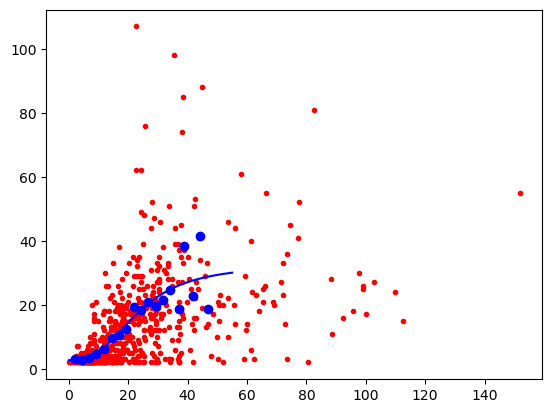

In [41]:
fit_model(rpe1.loc[:, ("Texas_Red", "mitosis")], True)

/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_9627/2761101608.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = xy_data.groupby("bins").mean()


(      Texas_Red  mitosis        bins
 468    0.000000        4         NaN
 594    0.157151        5         NaN
 316    2.321540        6  (1.5, 4.0]
 483    2.946775        8  (1.5, 4.0]
 616    2.961662        6  (1.5, 4.0]
 ..          ...      ...         ...
 216  130.417138        5         NaN
 619  130.996907       19         NaN
 94   137.523078       36         NaN
 153  148.853497        5         NaN
 140  180.300849       47         NaN
 
 [592 rows x 3 columns],
               Texas_Red    mitosis
 bins                              
 (1.5, 4.0]     3.416493   6.285714
 (4.0, 6.5]     5.158297   5.833333
 (6.5, 9.0]     7.691121   7.818182
 (9.0, 11.5]   10.182663   7.111111
 (11.5, 14.0]  12.548842   6.760000
 (14.0, 16.5]  15.008911   8.100000
 (16.5, 19.0]  17.306910  13.000000
 (19.0, 21.5]  20.387456   8.600000
 (21.5, 24.0]  22.689735  15.750000
 (24.0, 26.5]  25.272437  10.714286
 (26.5, 29.0]  27.395330  11.388889
 (29.0, 31.5]  30.493101  15.523810
 (31.5, 34.0]

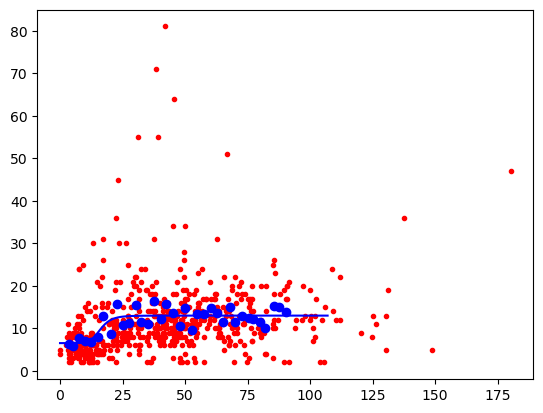

In [42]:
fit_model(hela.loc[:, ("Texas_Red", "mitosis")], True)

/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_33590/3557977316.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs = m3.groupby("labels").mean()
/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_33590/3557977316.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = m3.groupby("labels").std()
/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_33590/3557977316.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

[-8.58688561e+03  3.93441619e+01  2.44525307e+00  9.42742965e+00]


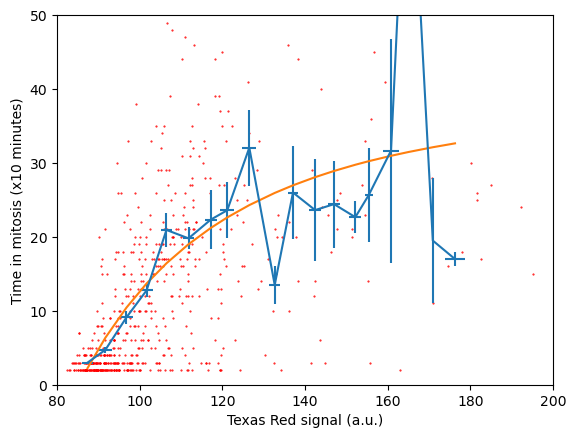

In [18]:
# pd.cut function returns a label vector with the label being the bin 
# that the row value belongs to.
binsize = 5
binrange = np.arange(m3.Texas_Red.min()+ binsize//2, 
                     180, binsize)

labels, bins = pd.cut(m3.Texas_Red, binrange, retbins=True)
m3["labels"] = labels
f, a = plt.subplots()
a.plot(m3.Texas_Red, m3.mitosis, 'r.', markersize= 1)
avgs = m3.groupby("labels").mean()
stds = m3.groupby("labels").std()
n = m3.groupby("labels").count()
# a.plot(avgs.Texas_Red, avgs.mitosis, 'bo', markersize=3)
a.errorbar(avgs.Texas_Red, avgs.mitosis, 
           yerr=stds.mitosis/np.sqrt(n.mitosis), xerr=stds.Texas_Red)
fits, _ = curve_fit(sigmoid_4par, avgs.Texas_Red, avgs.mitosis, 
                    p0 = [20, 200, 16, 90], maxfev=5000)

a.plot(avgs.Texas_Red, sigmoid_4par(avgs.Texas_Red,
                                       fits[0], fits[1], fits[2], fits[3]), '-')
plt.ylim([0, 50])
plt.xlim([80,200])
plt.xlabel('Texas Red signal (a.u.)')
plt.ylabel('Time in mitosis (x10 minutes)')
print(fits)

In [19]:
avgs.to_clipboard()

/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_33590/1698772629.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs = m6.groupby("labels").mean()
/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_33590/1698772629.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = m6.groupby("labels").std()
/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_33590/1698772629.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

ValueError: array must not contain infs or NaNs

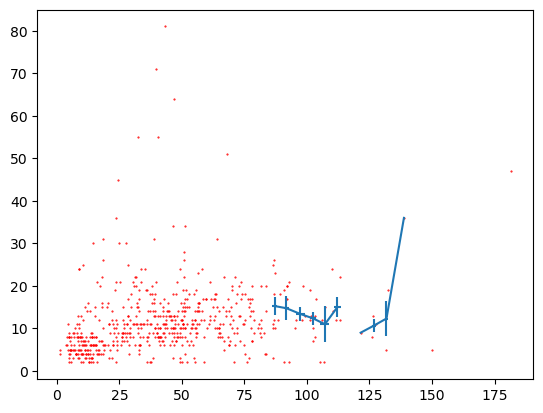

In [23]:
# pd.cut function returns a label vector with the label being the bin 
# that the row value belongs to.
binsize = 5
binrange = np.arange(m6.Texas_Red.min()+ binsize//2, 
                     180, binsize)

labels, bins = pd.cut(m6.Texas_Red-82, binrange, retbins=True)
m6["labels"] = labels
f, a = plt.subplots()
a.plot(m6.Texas_Red-82, m6.mitosis, 'r.', markersize= 1)
avgs = m6.groupby("labels").mean()
stds = m6.groupby("labels").std()
n = m6.groupby("labels").count()
# a.plot(avgs.Texas_Red, avgs.mitosis, 'bo', markersize=3)
a.errorbar(avgs.Texas_Red-82, avgs.mitosis, 
           yerr=stds.mitosis/np.sqrt(n.mitosis), xerr=stds.Texas_Red)
fits, _ = curve_fit(sigmoid_4par, avgs.Texas_Red - 82, avgs.mitosis, 
                    p0 = [20, 200, 16, 90], maxfev=5000)

a.plot(avgs.Texas_Red, sigmoid_4par(avgs.Texas_Red,
                                       fits[0], fits[1], fits[2], fits[3]), '-')
plt.ylim([0, 50])
plt.xlim([80,200])
plt.xlabel('Texas Red signal (a.u.)')
plt.ylabel('Time in mitosis (x10 minutes)')
print(fits)

/var/folders/kj/x0_bcbmd4jv3m3bf3430kc2r0000gr/T/ipykernel_89342/3299672843.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = m6.groupby("labels").mean()


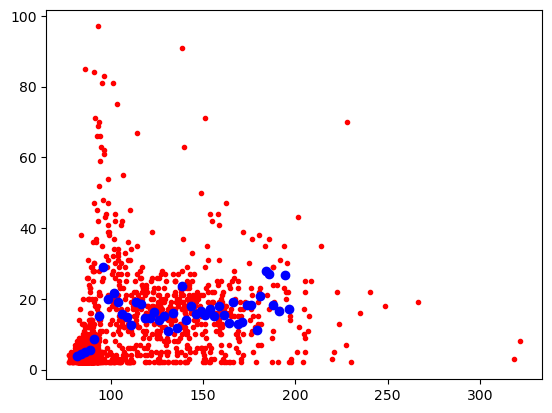

In [3]:

labels, bins = pd.cut(m6.Texas_Red,np.arange(80, 160, 2.5),retbins=True)
m6["labels"] = labels

plt.plot(m6.Texas_Red, m6.mitosis, 'r.')
means = m6.groupby("labels").mean()
plt.plot(means.Texas_Red, means.mitosis, 'bo')